In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import confusion_matrix

def cleaning(train_data):
    train_data['hours_entry'] = list(map(lambda x: int(x.split(':')[0]), train_data['time_entry']))
    train_data['minutes_entry'] = list(map(lambda x: int(x.split(':')[1]), train_data['time_entry']))
    train_data['seconds_entry'] = list(map(lambda x: int(x.split(':')[2]), train_data['time_entry']))

    train_data['hours_exit'] = list(map(lambda x: int(x.split(':')[0]), train_data['time_exit']))
    train_data['minutes_exit'] = list(map(lambda x: int(x.split(':')[1]), train_data['time_exit']))
    train_data['seconds_exit'] = list(map(lambda x: int(x.split(':')[2]), train_data['time_exit']))
    
    return train_data

def targetEval(hours_exit, x_exit, y_exit):
    if ((hours_exit==15) & 
        (x_exit < 3770901.5068) &
        (x_exit > 3750901.5068) &
        (y_exit > -19268905.6133) &
        (y_exit < -19208905.6133)):
        return 1
    else:
        return 0
    
def x_distance(x):
    if (x > 3770901.5068):
        return abs(x-3770901.5068)
    elif (x < 3750901.5068):
        return abs(x-3750901.5068)
    else:
        return 0
    
def y_distance(y):
    if (abs(y) > 19268905.6133):
        return abs(y)-19268905.6133
    elif (abs(y) < 19208905.6133):
        return abs(y)-19208905.6133
    else:
        return 0
    
def euclidian_distance(x, y, p=2):
    return (x**p+y**p)**(1/p)

cleaned_data = cleaning(pd.read_csv('data_train.csv').drop('Unnamed: 0', axis=1))

cleaned_data['city_center'] = list(map(lambda x: targetEval(x[14], x[9], x[10]), cleaned_data.values))

cleaned_data.dropna(inplace=True)
cleaned_data = cleaned_data.reset_index(drop=True).copy()

cleaned_data['x_distance'] = cleaned_data['y_entry'].apply(y_distance)
cleaned_data['y_distance'] = cleaned_data['x_entry'].apply(x_distance)
cleaned_data['euclidian_distance'] = euclidian_distance(cleaned_data['x_distance'], cleaned_data['y_distance'])

# Selecting the variables
df = cleaned_data[['vmax','vmin','vmean',
#                    'x_entry','y_entry',
                   'hours_entry','minutes_entry','seconds_entry',
                   'x_distance','y_distance', 
                   'euclidian_distance']].copy()
df_w_city_center = cleaned_data[['vmax','vmin','vmean',
#                                  'x_entry','y_entry',
                                 'hours_entry','minutes_entry','seconds_entry', 
                                 'x_distance','y_distance', 
                                 'euclidian_distance',
                                 'city_center']].copy()
# Removing outliers
no_outliers = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)].reset_index(drop=True)
# Scaling and PCA
ss = StandardScaler()
pca = PCA(n_components='mle', random_state=0)
# Separating variables
X = df.iloc[no_outliers.index]
y = df_w_city_center.iloc[no_outliers.index]['city_center']

from collections import Counter
print('Original dataset shape %s' % Counter(y))

In [75]:
# # Oversampling
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=0, n_jobs=-1)
# X_res, y_res = sm.fit_resample(X, y)

# má amostra
# from collections import Counter
# from imblearn.under_sampling import NearMiss
# nm = NearMiss()
# X_res, y_res = nm.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

# parece bão - mas não é
# from collections import Counter
# from imblearn.under_sampling import RepeatedEditedNearestNeighbours # doctest : +NORMALIZE_WHITESPACE
# print('Original dataset shape %s' % Counter(y))
# renn = RepeatedEditedNearestNeighbours()
# X_res, y_res = renn.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

# muito cheio
# from imblearn.under_sampling import AllKNN
# print('Original dataset shape %s' % Counter(y))
# allknn = AllKNN(random_state=0, n_jobs=-1)
# X_res, y_res = allknn.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

# from imblearn.under_sampling import NeighbourhoodCleaningRule # doctest: +NORMALIZE_WHITESPACE
# print('Original dataset shape %s' % Counter(y))
# ncr = NeighbourhoodCleaningRule(n_jobs=-1, random_state=0, n_neighbors=5)
# X_res, y_res = ncr.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

# cc = ClusterCentroids(estimator=model ,random_state=42, n_jobs=-1)
# X_res, y_res = cc.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

# from imblearn.combine import SMOTEENN
# from imblearn.over_sampling import SMOTE

# smt = SMOTEENN(ratio='auto', smote=SMOTE(n_jobs=-1, random_state=420), random_state=420)
# X_smt, y_smt = smt.fit_sample(X, y)

In [3]:
X_smt = X
y_smt = y

In [402]:
print('Resampled dataset shape %s' % Counter(y_smt))

Resampled dataset shape Counter({0: 233031, 1: 8411})


In [5]:
# PCA and scaling
# X_resampled = ss.fit_transform(pca.fit_transform(X_smt))
# Just Scaling
X_resampled = ss.fit_transform(X_smt)

# Spliting
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_smt, 
                                                    test_size=0.33,
                                                    random_state=0)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
clustering = {}

min_clu = 2
max_clu = 8
cluster_df = X_smt[['vmax', 'vmean', 'vmin', 
                    'hours_entry','minutes_entry','seconds_entry',
                    'euclidian_distance']].copy()
cluster_df['city_center'] = y_smt

from sklearn.cluster import KMeans

for x in range(min_clu, max_clu):
    model = KMeans(n_clusters=x , n_jobs=-1, verbose=True, random_state=420)
    results = model.fit_predict(cluster_df)
    clustering[x] = [model, 
                     results, 
                     model.inertia_, 
                     model.cluster_centers_]
    print(f"\r {x} done!")
    
# from sklearn.metrics import silhouette_score
# score_silhouette = []

# for x in list(clustering.keys()):
#     score_silhouette.append(silhouette_score(no_outliers, clustering[x][0].labels_))
#     print(x, 'done!')

# score_df['silhouette_score'] = score_silhouette
# score_df.silhouette_score.plot(figsize=(12,8), xticks=range(2, 8)).grid()

 2 done!
 3 done!
 4 done!
 5 done!
 6 done!
 7 done!


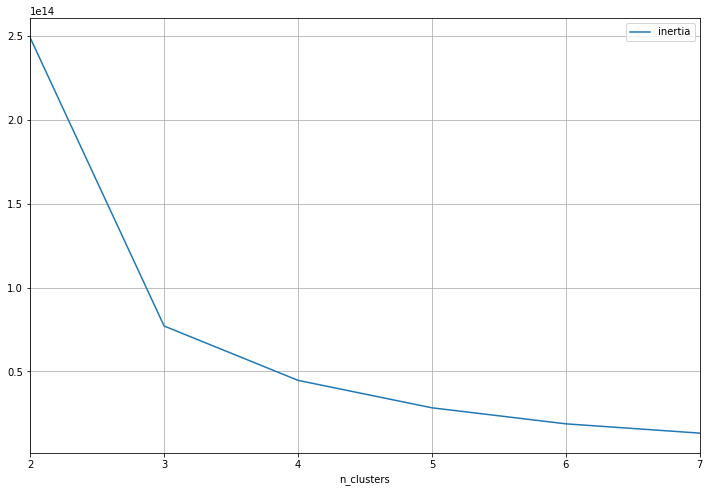

In [8]:
inertia = [(x, clustering[x][2]) for x in clustering.keys()]
score_df = pd.DataFrame(inertia, columns=['n_clusters','inertia']).set_index('n_clusters')
score_df.plot(figsize=(12,8), xticks=range(min_clu, max_clu)).grid()

In [324]:
from sklearn.ensemble import RandomForestClassifier

ensemble_clf = RandomForestClassifier(n_estimators=500,verbose=True, n_jobs=-1, random_state=0, class_weight='balanced')
ensemble_clf.fit(X_train, y_train.ravel())
print(f1_score(y_test, ensemble_clf.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, ensemble_clf.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   48.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.5s finished


0.8875333587495233


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.6s finished


tn: 76758 fp: 198 fn: 392 tp: 2328


In [336]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=350, learning_rate=0.01, random_state=0).fit(X_train, y_train)
print(f1_score(y_test, gbc.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, gbc.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

0.8898831717623663
tn: 58128 fp: 154 fn: 289 tp: 1790


In [21]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=150, verbosity=1, silent=0, 
                        objective='binary:logistic', booster='gbtree', n_jobs=-1, gamma=5,
                        min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0.01, reg_lambda=0.01, 
                        scale_pos_weight=1, base_score=0.5, random_state=0, missing=None)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["aucpr","error"]
xgb_clf.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=0)
# xgb_clf.fit(X_train, y_train)
print(f1_score(y_test, xgb_clf.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, xgb_clf.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

0.891593761886649
tn: 76762 fp: 194 fn: 376 tp: 2344


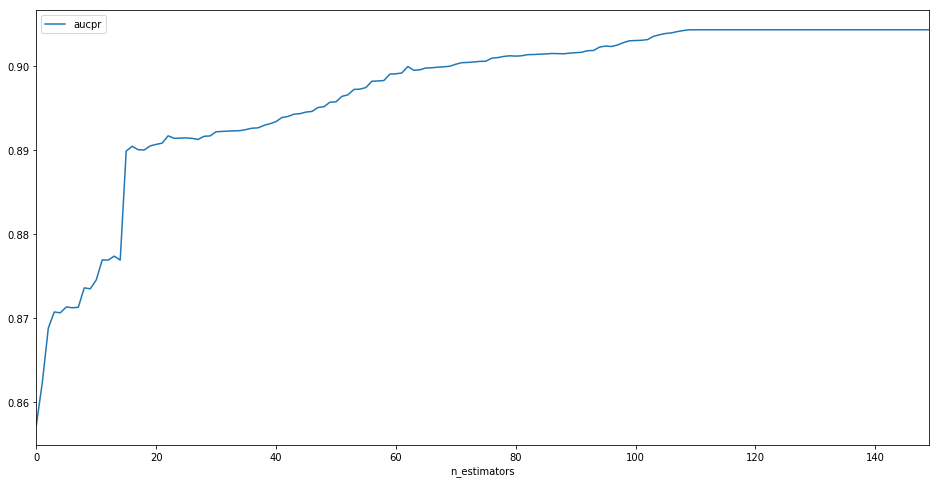

In [23]:
val_res = pd.DataFrame(xgb_clf.evals_result_['validation_0'])
val_res['n_estimators'] = list(range(len(val_res)))
val_res.plot(x='n_estimators', y='aucpr', figsize=(16,8))

In [330]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=12, n_jobs=-1)
neigh.fit(X_train, y_train)
print(f1_score(y_test, neigh.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, neigh.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

0.8399600399600399
tn: 76773 fp: 183 fn: 618 tp: 2102


In [331]:
from sklearn.svm import SVC

clf = SVC(random_state=420, C=0.06, verbose=True)
clf.fit(X_train, y_train.ravel())
print(f1_score(y_test, clf.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print('tn:', tn,'fp:', fp,'fn:', fn,'tp:', tp)

[LibSVM]

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8565005620082428
tn: 76624 fp: 332 fn: 434 tp: 2286


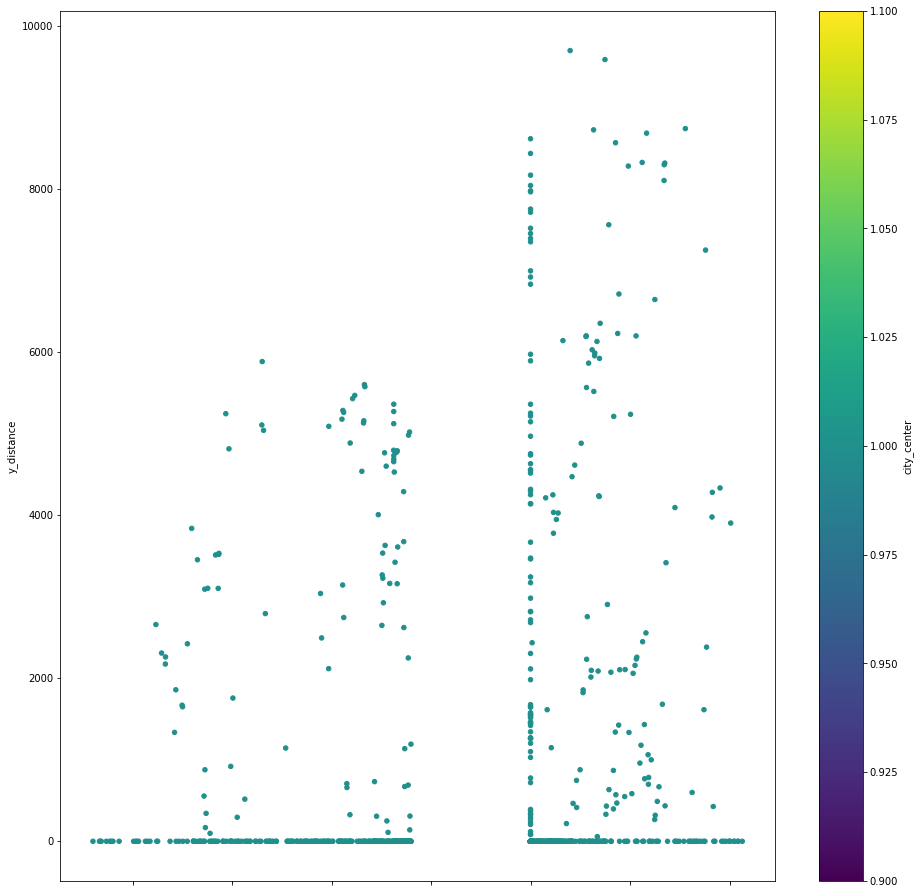

In [409]:
df_w_city_center[['x_distance', 
                  'y_distance', 
                  'city_center']][df_w_city_center['city_center']==1].plot.scatter(x='x_distance',
                                                                                   y='y_distance',
                                                                                   c='city_center',
                                                                                   figsize=(16,16),
                                                                                   colormap='viridis')


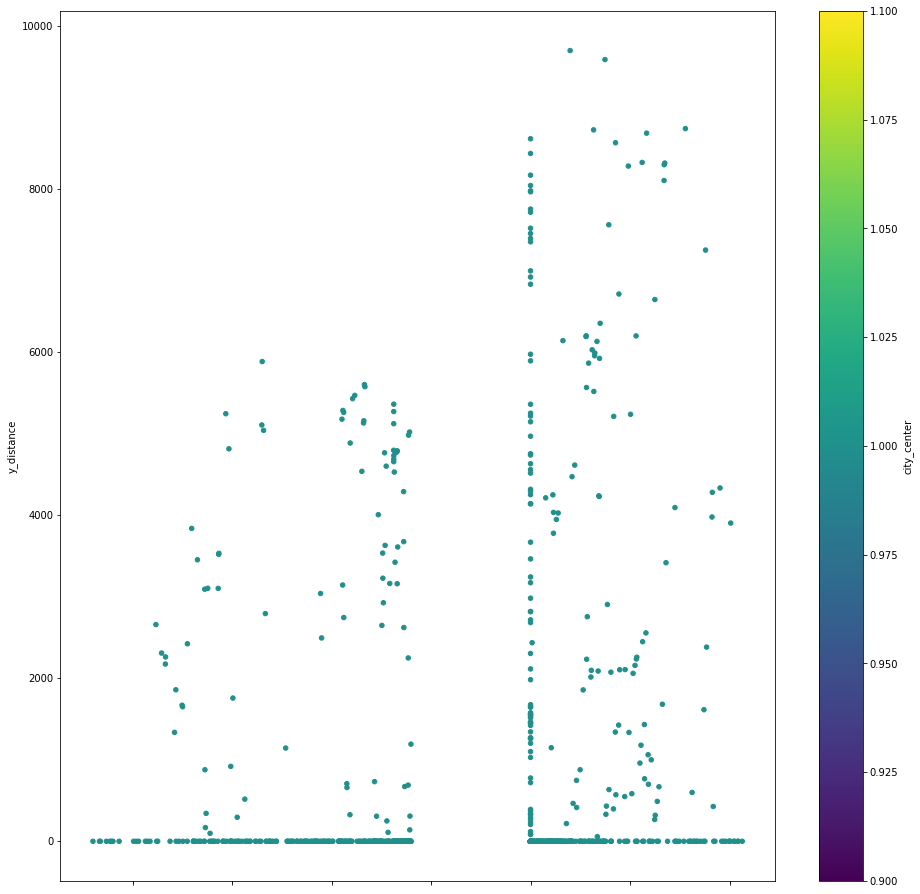

In [410]:
# # import pandas_profiling

# # pandas_profiling.ProfileReport(df_w_city_center)

aa = pd.DataFrame(X_smt, columns = ['vmax','vmin','vmean', 
                                    'x_entry','y_entry', 
                                    'hours_entry','minutes_entry','seconds_entry', 
                                    'x_distance','y_distance', 
                                    'euclidian_distance'])

aa['city_center'] = y_smt
aa['cluster_predict_4'] = clustering[5][1]

aa[['x_distance', 'y_distance', 
    'cluster_predict_4', 'city_center']][(aa['city_center']==1)].plot.scatter(x = 'x_distance',
                                                                            y = 'y_distance',
                                                                            c = 'city_center', 
                                                                            colormap = 'viridis',
                                                                            figsize = (16,16))

In [24]:
# aa[['euclidian_distance', 'cluster_predict_4']].plot.hist(x='euclidian_distance', y='cluster_predict_4')

In [296]:
test_data = pd.read_csv('data_test.csv').drop('Unnamed: 0', axis=1)

test_data = test_data[np.isnan(test_data['x_exit'])].copy()
test_data = cleaning(test_data).fillna(0).copy()
test_data['x_distance'] = test_data['y_entry'].apply(y_distance)
test_data['y_distance'] = test_data['x_entry'].apply(x_distance)
test_data['euclidian_distance'] = euclidian_distance(test_data['x_distance'], test_data['y_distance'])

test_data['target'] = xgb_clf.predict(ss.transform(test_data[['vmax','vmin','vmean',
                                                                                 'x_entry','y_entry',
                                                                          'hours_entry','minutes_entry','seconds_entry',
                                                                         'x_distance','y_distance', 
                                                                         'euclidian_distance']]))
submission = test_data[['trajectory_id','target']].copy()
submission['id'] = test_data['trajectory_id']
submission = submission[['id', 'target']].copy()
submission.to_csv('firsttry.csv', index=False)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


In [3]:
# pca_plot = PCA(n_components=2, random_state=0)
# data_to_plot = pca_plot.fit_transform(df.iloc[no_outliers.index])
# pcadataplot = pd.DataFrame(data_to_plot, columns=['x','y'])
# pcadataplot['target'] = df_w_city_center.iloc[no_outliers.index].city_center.apply(bool)
# pcadataplot.plot(x='x', y='y', c=pcadataplot.target, colorbar=True, kind='scatter', figsize=(16,16))

In [332]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

def recall_metric(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Building the model
mlp_model = Sequential()
mlp_model.add(Dense(6, activation='relu', input_shape=(11,)))
mlp_model.add(Dense(1, activation='softmax'))

# Compiling the model
mlp_model.compile(loss = f1_loss, optimizer='rmsprop', metrics=[precision_metric, recall_metric, f1_metric])
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                384       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


In [333]:
# Training the model
mlp_model.fit(X_train, y_train, epochs=100, verbose=True)
# Evaluating the model on the training and testing set
score = mlp_model.evaluate(X_train, y_train)
print("\n Training Accuracy:", score[1])
score = mlp_model.evaluate(X_test, y_test)
print("\n Testing Accuracy:", score[1]) 

Epoch 1/100
161766/161766 [==============================] - 8s 46us/step - loss: 0.9339 - precision_metric: 0.0352 - recall_metric: 0.6809 - f1_metric: 0.0661
Epoch 2/100
161766/161766 [==============================] - 7s 42us/step - loss: 0.9339 - precision_metric: 0.0352 - recall_metric: 0.6783 - f1_metric: 0.0661
Epoch 3/100
161766/161766 [==============================] - 7s 42us/step - loss: 0.9339 - precision_metric: 0.0352 - recall_metric: 0.6815 - f1_metric: 0.0661
Epoch 4/100
161766/161766 [==============================] - 7s 42us/step - loss: 0.9339 - precision_metric: 0.0352 - recall_metric: 0.6831 - f1_metric: 0.0661
Epoch 5/100
161766/161766 [==============================] - 7s 42us/step - loss: 0.9339 - precision_metric: 0.0352 - recall_metric: 0.6856 - f1_metric: 0.0661
Epoch 6/100
161766/161766 [==============================] - 7s 42us/step - loss: 0.9339 - precision_metric: 0.0352 - recall_metric: 0.6850 - f1_metric: 0.0661
Epoch 7/100
161766/161766 [=============

79676/79676 [==============================] - 1s 16us/step

 Testing Accuracy: 0.03413825995280888


In [171]:
f1_score(y_test, mlp_model.predict(X_test))

0.6674737746829528

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score, make_scorer

def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

# A parameter grid for XGBoost
params = {
        'gamma':[0.5, 1, 2, 5],
        'max_depth':[1, 3, 5],
        'learning_rate':[0.001, 0.01], 
        'n_estimators':[250 , 900, 1000],
        'max_delta_step':[0, 0.1, 0.001, 0.2],  
        'reg_alpha':[0.01, 0.1, 0.9, 0], 
        'reg_lambda':[0.01, 0.9, 0], 
        'base_score':[0.5, 0.1, 0.9]
        }

xgb_clf = XGBClassifier(objective='binary:logistic',booster='gbtree', n_jobs=-1, random_state=420)

# eval_set = [(X_train, y_train), (X_test, y_test)]
# eval_metric = ["aucpr","error"]

folds = 5
param_comb = 5

from sklearn.metrics import precision_recall_curve, auc, fbeta_score, balanced_accuracy_score

def pr_auc_score(y_true, y_score):
    """
    Generates the Area Under the Curve for precision and recall.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    return auc(recall, precision)

scorer = {'ROC_AUC':'roc_auc',
          'RECALL':'recall'
          "F1":make_scorer(f1_score, greater_is_better=True),
          'Balanced_Accuracy':make_scorer(balanced_accuracy_score, greater_is_better=True),
          'PR_CURVE':make_scorer(pr_auc_score, greater_is_better=True, needs_proba=True)
         }

random_search = GridSearchCV(xgb_clf, param_grid=params, 
                           scoring=scorer, n_jobs=-1, cv=folds, 
                           verbose=True, refit='ROC_AUC')

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_resampled, y_smt
#                   , eval_metric=eval_metric, eval_set=eval_set
                 )
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 60.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 241.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 468.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 615.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 781.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 993.3min


KeyboardInterrupt: 

In [40]:
random_search.decision_function

AttributeError: 'XGBClassifier' object has no attribute 'decision_function'

In [ ]:
'''
    File name: pso_v4.py
    Author: Anderson Henrique de Oliveira Conceicao
    Date created: 29/05/2017
    Date last modified: 02/06/2017
    Python Version: 2.7
'''
from math import sqrt, pow, cos, pi, exp
import random
import numpy as np
from numpy import inf, array
import scipy as sp
 
def run(MaxIt=10000):       #MaxIt - Maximum number of iterations

    #Problem Definition=================================================================================================
    
    def polyRel(bad_lim, good_lim, degree):  #Creates an array with the coefficients of the polynom
        if bad_lim < good_lim:                            
            first_x = bad_lim
            second_x = good_lim
            first_y = abs(1-(bad_lim/good_lim))
            second_y = 0
        elif bad_lim == good_lim:
            first_x = bad_lim*0.5
            second_x = good_lim
            first_y = 1-(first_x/good_lim)
            second_y = 0
            if first_x < 0 or first_x<second_x:
                first_x = good_lim
                second_x = good_lim*1.5
                first_y = 0
                second_y = abs(1-(good_lim/second_x))
        else:
            first_x = good_lim
            second_x = bad_lim
            first_y = 0
            second_y = abs(1-(bad_lim/good_lim))
    
        X = [ 0, first_x, second_x, 1 ]
        Y = [ 1, first_y, second_y, 1 ]
        
        try:
            P = sp.polyfit(X, Y, degree)
        except sp.RankWarning :             #To adjust if the polynom is not well conditioned
            P = sp.polyfit(X, Y, degree-1)
    
        return P

#     #It creates the polynom that defines the parameter dynamics
#     #                    Bad     Good  Degree
#     P0 = list(polyRel( 0.57962, 0.59091, 3))    #AAET    
#     P1 = list(polyRel( 0.58664, 0.59591, 3))    #AAST
#     P2 = list(polyRel( 0.00292, 0.00021, 3))    #VI
#     P3 = list(polyRel( 0.11682, 0.07932, 3))    #QMA
#     P4 = list(polyRel( 0.11947, 0.12379, 3))    #IMAI
#     P5 = list(polyRel( 0.58417, 0.58726, 3))    #VA
    
    # Polynomial translation         A*X^3    +    B*X^2   +    C*X^1   +    D*X^0 =====================================
    def polyeval(x, poly): return poly[0]*x**3+poly[1]*x**2+poly[2]*x**1+poly[3]*x**0
    
    def fitnessFunc(x):
#         AAET = polyeval(x[0], P0)   # AAET =  x[0] ;
#         AAST = polyeval(x[1], P1)   # AAST =  x[1] ;
#         VI   = polyeval(x[2], P2)   # VI   =  x[2] ; 
#         QMA  = polyeval(x[3], P3)   # QMA  =  x[3] ;
#         IMAI = polyeval(x[4], P4)   # IMAI =  x[4] ;
#         VA   = polyeval(x[5], P5)   # VA   =  x[5].
#         #Fitness function
#         try: return ((VA/(AAST-AAET))*(VI/(AAST-AAET))**(-1)*(AAST/AAET)**(-1)*(QMA/IMAI)**(-1))
#         except ZeroDivisionError: return 'inf'
        x[0]*
                                                                        
    nVar = 3                            #Number of dimensions                         
    VarMin = 0                          #Lower bound of decision variables              
    VarMax = 1                          #Upper bound of decision variables             
    MaxVelocity = 0.002*(VarMax-VarMin) #Velocity upper bound            
    MinVelocity = -MaxVelocity          #Velocity lower bound               
    
    #Constriction coefficients==========================================================================================
    kappa = 1
    phi1 = 2.05
    phi2 = 2.05
    phi = phi1 + phi2
    chi = 2*kappa/abs(2-phi-sqrt(phi**2-4*phi))     
    random.seed(0)
    
    #Parameters of PSO==================================================================================================
    range_cost = 1.5         #Defines the range in which the algorithm will adjust around zero cost
    nPop = 35                #Population size (swarm size)
    w = chi                  #Inertia coefficient
    c1 = chi*phi1            #Personal acceleration coefficient
    c2 = chi*phi2            #Social acceleration coefficient
    GlobalBestCost = '-inf'  #Global best cost
    GlobalBestPosition = []  #Global best position
    Swarm = []               #Swarm population array
    
    #Useful functions===================================================================================================

    #Unnormalize the value
    def unnormalize(n,min,max): 
        return (max-min)*n+min  #unnormalize(number, minimum value, maximal value)
    #Creates an array of random numbers
    def randArray(size):        
        aux = []
        for i in xrange(0,size): aux.append(random.uniform(VarMin,VarMax))
        return aux
    #It limits the number in a defined range
    def clamp(x,max,min):             #clamp(array, max bound, min bound);
        if isinstance(x, list):       #or clamp(scalar, max bound, min bound);
            for i in xrange(0, len(x)):
                if x[i] >= max: x[i] = max
                elif x[i] <= min: x[i] = min
        else:
            if x >= max: x = max
            elif x <= min: x = min
        return x
    
    #Class definition===================================================================================================
    class Particle(object):              #Defining the Particle's class
        def __init__(self, Position=None, Velocity=None, \
            Cost=None, BestPosition=None, BestCost=None):

            self.Position =[]            #Characteristics of the particle
            self.Velocity = []
            self.Cost = 0
            self.BestPosition = []
            self.BestCost = []
    
    #Initializing the algorithm=========================================================================================
    #Swarm population array
    for i in xrange(0,nPop): Swarm.append(Particle())
    
    #Initialize population members
    for i in xrange(0,nPop):
        #Generate random solution
        Swarm[i].Position = list(randArray(nVar))       
        #Initialize velocity
        Swarm[i].Velocity = np.zeros(nVar)                    
        #Evaluation
        Swarm[i].Cost = fitnessFunc(Swarm[i].Position) 
        #Update personal best position
        Swarm[i].BestPosition = list(Swarm[i].Position)       
        #Update personal best cost
        Swarm[i].BestCost = Swarm[i].Cost               
        #It compares with the Global Best Cost and updates the value
        if Swarm[i].BestCost < GlobalBestCost:
            GlobalBestCost = Swarm[i].BestCost
            GlobalBestPosition = list(Swarm[i].BestPosition)
    
    #Array to hold best cost value on each iteration
    BestCosts = []
    BestPositions = []
    BestCosts.append(GlobalBestCost)
    BestPositions.append(GlobalBestPosition)
    
    #Main loop of PSO
    for i in xrange(1,MaxIt):
        
        for j in xrange(0,nPop):
            # Update Velocity: v = w*v + c1*rand*(pbest-x) + c2*rand*(gbest-x)
            Swarm[j].Velocity = list(w*np.array(Swarm[j].Velocity) \
                                +c1*random.uniform(0,1)*(np.array(Swarm[j].BestPosition)-np.array(Swarm[j].Position)) \
                                +c2*random.uniform(0,1)*(np.array(GlobalBestPosition)-np.array(Swarm[j].Position)))
            #Applying lower and upper bound limits
            Swarm[j].Velocity = clamp(Swarm[j].Velocity, MaxVelocity, MinVelocity)         
            #Update position
            Swarm[j].Position = np.array(Swarm[j].Position) + np.array(Swarm[j].Velocity)  
            #Applying lower and upper bound limits, by defining 
            #the lower bound limit as: mean - standard deviations
            #and the upper bound limits as: mean + standard deviations
            Swarm[j].Position[0] = clamp(Swarm[j].Position[0], 1, 0.16667)             # x = AAET = x[0] ;
            Swarm[j].Position[1] = clamp(Swarm[j].Position[1], 1, 0.16667)             # y = AAST = x[1] ;
            Swarm[j].Position[2] = clamp(Swarm[j].Position[2], 0.00021+0.00075, 0)     # z =  VI  = x[2] ;
            Swarm[j].Position[3] = clamp(Swarm[j].Position[3], 0.07932+0.12049, 0)     # v = QMA  = x[3] ;
            Swarm[j].Position[4] = clamp(Swarm[j].Position[4], 0.12379+0.12910, 0)     # w = IMAI = x[4] ;
            Swarm[j].Position[5] = clamp(Swarm[j].Position[5], 0.97727, 0)             # u =  VA  = x[5] .
            #Evaluation
            Swarm[j].Cost = fitnessFunc(Swarm[j].Position)
            #Update personal best
            if (Swarm[j].Cost <= Swarm[j].BestCost and Swarm[j].Cost > -range_cost) or\
               (Swarm[j].Cost >= Swarm[j].BestCost and Swarm[j].Cost < range_cost):
                Swarm[j].BestPosition = list(Swarm[j].Position)  
                Swarm[j].BestCost = Swarm[j].Cost
            #Update global best
            if (Swarm[j].BestCost <= GlobalBestCost and Swarm[j].BestCost > -range_cost) or\
               (Swarm[j].BestCost >= GlobalBestCost and Swarm[j].BestCost < range_cost):          
                GlobalBestCost = Swarm[j].BestCost
                GlobalBestPosition = list(Swarm[j].Position)
            #Stores the best cost value
            BestCosts.append(GlobalBestCost)         
            #Stores the best position    
            BestPositions.append(GlobalBestPosition) 

    #Unnormalizing the variables by the limits defined on the table=====================================================
    AAET = unnormalize(BestPositions[-1][0], 0, 4387014266.17000)
    AAST = unnormalize(BestPositions[-1][1], 0, 2561890616.28000)
    VI   = unnormalize(BestPositions[-1][2], 25.18000, 268931997.14000)
    QMA  = unnormalize(BestPositions[-1][3], 1, 63)
    IMAI = unnormalize(BestPositions[-1][4], 0, 1056)
    VA   = unnormalize(BestPositions[-1][5], 0, 39944239.59000)
    
    # x = AAET = x[0] ; y = AAST = x[1] ; z = VI = x[2] ; v = QMA = x[3] ; w = IMAI = x[4] ; u = VA = x[5]==============
    print "The results are ready!", "\n"
    print "This was the Best Cost:", BestCosts[-1]
    print "This was the Best Position:", BestPositions[-1]

    return BestCosts[-1],BestPositions[-1]



In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

def recall_metric(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def precision_loss(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return 1-precision

def f1_metric(y_true, y_pred):
    
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Building the model
mlp_model = Sequential()
mlp_model.add(Dense(6, activation='relu', input_shape=(11,)))
mlp_model.add(Dense(1, activation='sigmoid'))

# Compiling the model
mlp_model.compile(loss = 'accuracy', optimizer='rmsprop', metrics=[precision_metric])
mlp_model.summary()